# Homework 4

## Import Libraries and data
data source: [https://www.kaggle.com/datasets/kannan1314/amazon-stock-price-all-time]

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import torch.optim as optim
import tensorflow_hub as tfhub
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from scipy.spatial.distance import chebyshev
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

import warnings
warnings.filterwarnings('ignore')

In [2]:
# set seed to get reproducible results
seed_value= 184
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
df = pd.read_csv('./Amazon.csv', parse_dates=True , index_col="Date")

## EDA
There is no null value so I don't need to do imputation. There is no duplicate value so I don't need to do data cleaning. The dates range from 1997-05-15 to 2021-10-27. Based on the visualization, the stock price before 2015 isn't changing much so I will only use data from 2015 to 2021. I will choose 'Close' to predict.

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-21,3414.25000,3440.280029,3403.000000,3435.010010,3435.010010,1881400
2021-10-22,3421.00000,3429.840088,3331.300049,3335.550049,3335.550049,3133800
2021-10-25,3335.00000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
2021-10-26,3349.51001,3416.120117,3343.979980,3376.070068,3376.070068,2693700
2021-10-27,3388.00000,3412.000000,3371.453369,3396.189941,3396.189941,1080291


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6155 entries, 1997-05-15 to 2021-10-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6155 non-null   float64
 1   High       6155 non-null   float64
 2   Low        6155 non-null   float64
 3   Close      6155 non-null   float64
 4   Adj Close  6155 non-null   float64
 5   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 336.6 KB


In [7]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6155 entries, 1997-05-15 to 2021-10-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6155 non-null   float64
 1   High       6155 non-null   float64
 2   Low        6155 non-null   float64
 3   Close      6155 non-null   float64
 4   Adj Close  6155 non-null   float64
 5   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 336.6 KB


In [8]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6.155000e+03
mean,520.556302,526.216132,514.277282,520.429832,520.429832,7.329010e+06
std,857.161696,865.821041,847.270905,856.668492,856.668492,7.149521e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.750000,39.514999,38.104999,38.821251,38.821251,3.579350e+06
50%,92.669998,94.190002,90.750000,92.639999,92.639999,5.470000e+06
75%,528.949982,535.304993,521.950012,529.450012,529.450012,8.294950e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


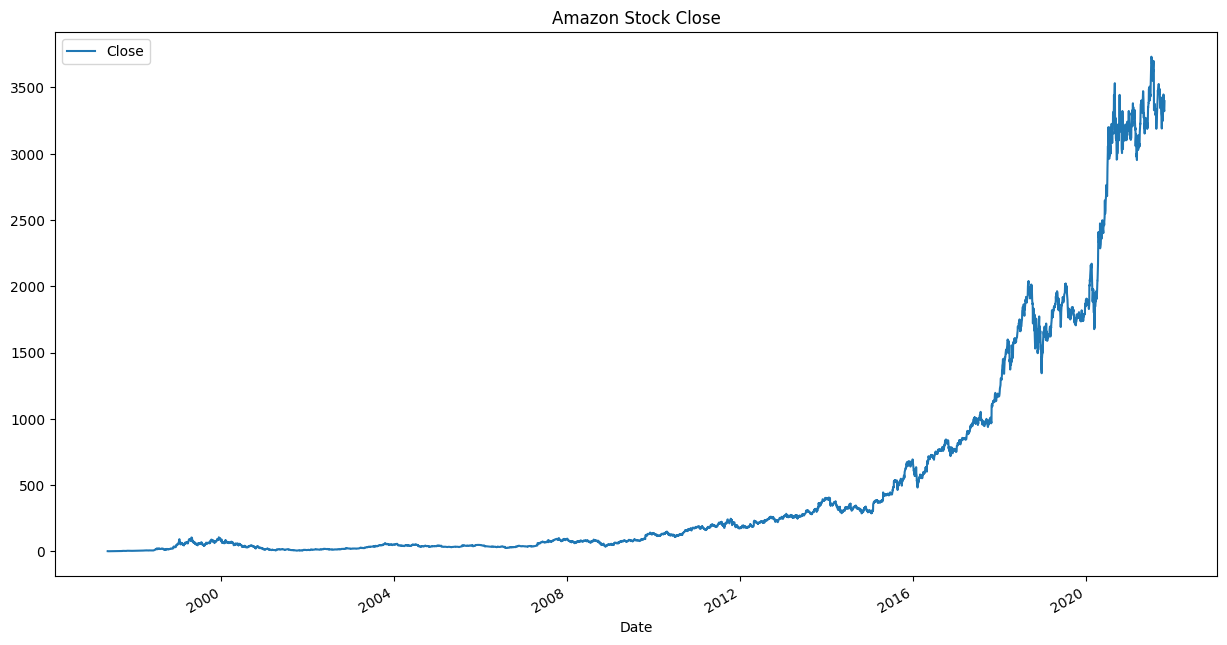

In [10]:
df[['Close']].plot(figsize = (15, 8))
plt.title('Amazon Stock Close')
plt.show()

### Stationary test
Perform KPSS stationary test. Although RNNs can predict non-stationary data, it is always good to check the stationary of a time series since a stationary data is easier for models to learn.

In [11]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n')

In [12]:
kpss_test(df['Close'])

KPSS Statistic: 8.061015470906401
p-value: 0.01
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



KPSS Statistic: 1.0435707471828748
p-value: 0.01
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



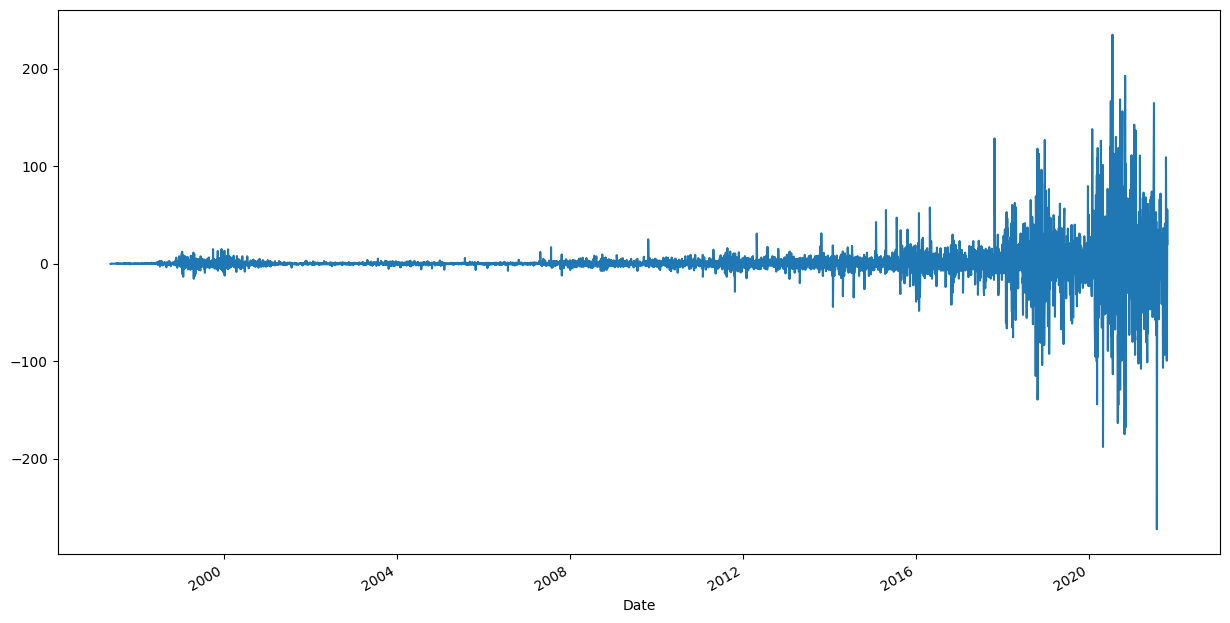

In [13]:
df['close_diff'] = df['Close'] - df['Close'].shift(1)
kpss_test(df['close_diff'].dropna())
plt.figure(figsize=(15, 8))
df['close_diff'].dropna().plot()
plt.show()

## Data Preprocessing

### Split dataset
I will use 2015 to 2018 as train data(1004, 2, 1), 2019 to 2020 as validation data(503, 2, 1), 2020 to 2021 as test data(205, 2, 1). The sequence length I choose is 2 which means the value of previous day will be used to predict the value of next day.

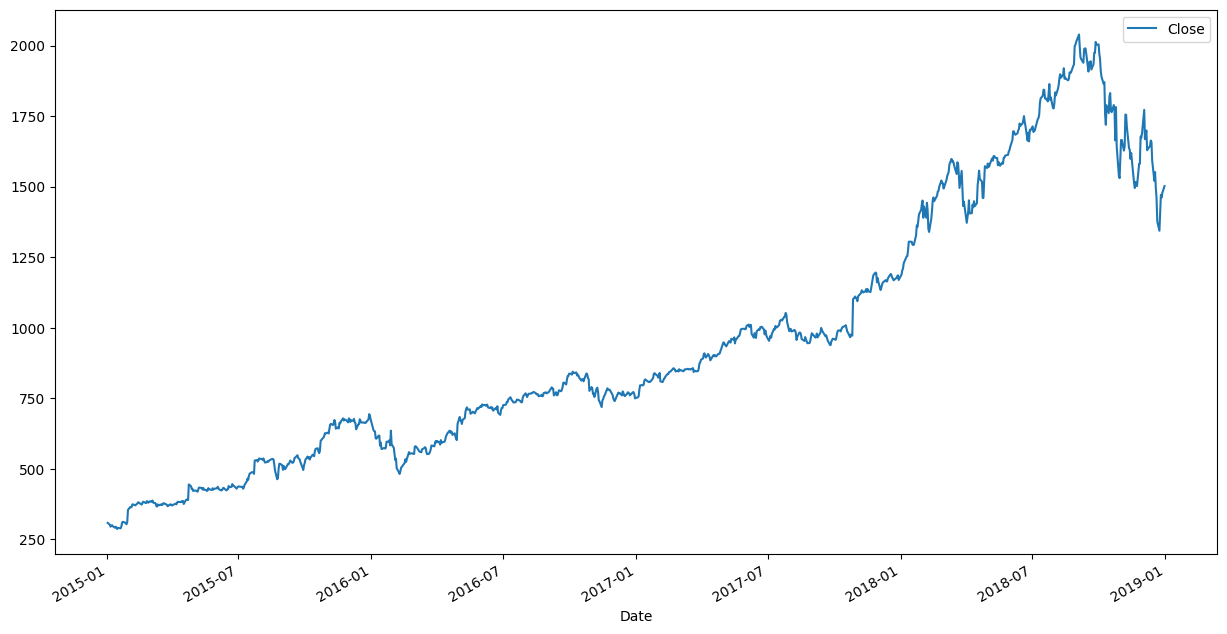

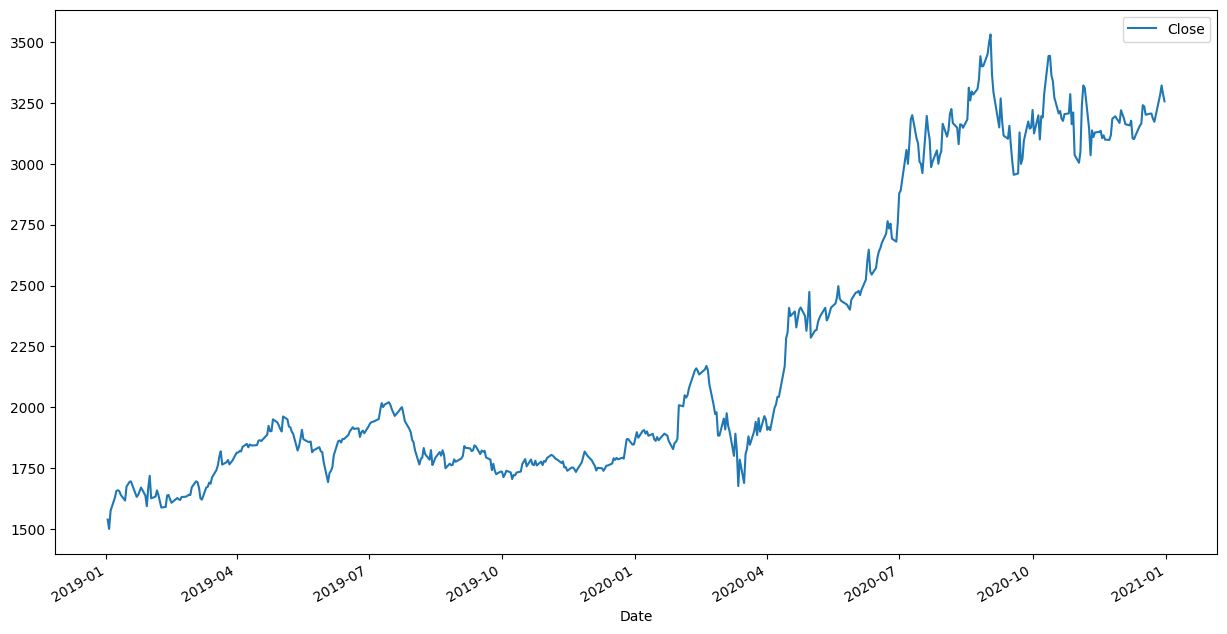

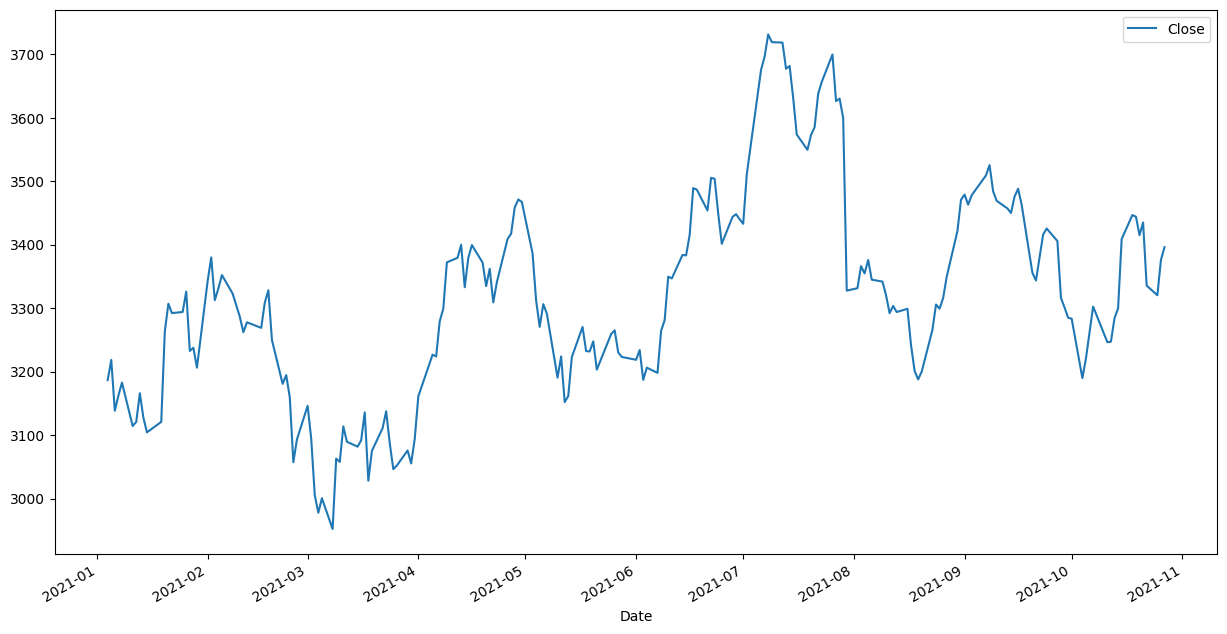

In [14]:
data = df[['Close']]['2015':]
train_data = data[:'2018']
val_data = data['2019':'2020']
test_data = data['2021':]
train_data.plot(figsize=(15, 8))
plt.show()
val_data.plot(figsize=(15, 8))
plt.show()
test_data.plot(figsize=(15, 8))
plt.show()

In [15]:
kpss_test(train_data['Close'])

KPSS Statistic: 4.609614635042011
p-value: 0.01
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



In [16]:
kpss_test(val_data['Close'])

KPSS Statistic: 3.0324485994855723
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



In [17]:
kpss_test(test_data['Close'])

KPSS Statistic: 0.8118484971041708
p-value: 0.01
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary



In [18]:
def split_series(series, seq_length):
    X = []
    Y = []
    for i in range(seq_length, len(series.values)):
        X.append(series.values[i - seq_length: i])
        Y.append(series.values[i])
    
    return np.array(X), np.array(Y)

In [19]:
seq_length = 2
X_train, Y_train = split_series(train_data, seq_length=seq_length)
X_val, Y_val = split_series(val_data, seq_length=seq_length)
X_test, Y_test = split_series(test_data, seq_length=seq_length)
X_train.shape, X_val.shape, X_test.shape

((1004, 2, 1), (503, 2, 1), (205, 2, 1))

## Models
The activation function I used for all three model(including for each time step and output) is 'ReLU'. All three models have 3 layers, a RNN/LSTM/GRU layer(all have 50 hidden states) and two dense layer(the last layer output a predict value). The cost function I used is Mean Squared Error and I used Mean Absolute Error for checking the performance.

### Hyperparameters

In [20]:
N_EPOCHS = 20
BATCH_SIZE = 16

### RNN

In [21]:
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(50, activation='relu'))
rnn_model.add(layers.Dense(25, activation='relu'))
rnn_model.add(layers.Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
rnn_results = rnn_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
rnn_history = pd.DataFrame(rnn_results.history)

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 451026.5312 - mean_absolute_error: 497.7259 - val_loss: 30274.1074 - val_mean_absolute_error: 157.8154
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 2060.3765 - mean_absolute_error: 30.3695 - val_loss: 3630.8694 - val_mean_absolute_error: 41.8977
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 705.6318 - mean_absolute_error: 16.2584 - val_loss: 3559.3745 - val_mean_absolute_error: 41.2496
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 709.6505 - mean_absolute_error: 16.3672 - val_loss: 3631.8882 - val_mean_absolute_error: 41.8783
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 717.5674 - mean_absolute_error: 16.4600 - val_loss: 3543.5095 - val_mean_absolute_error: 41.1739
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 706.8560 - mean_absolute_error: 16.3739 - val_loss: 3535.9448 - val_mean_abs

In [22]:
rnn_val_preds = rnn_model.predict(X_val)
rnn_test_preds = rnn_model.predict(X_test)
rnn_val_mae = MeanAbsoluteError()(Y_val, rnn_val_preds)
rnn_test_mae = MeanAbsoluteError()(Y_test, rnn_test_preds)
rnn_val_preds.shape, rnn_test_preds.shape

7/7 [==============================] - 0s 936us/step


((503, 1), (205, 1))

### LSTM

In [23]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(50, activation='relu'))
lstm_model.add(layers.Dense(25, activation='relu'))
lstm_model.add(layers.Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
lstm_results = lstm_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
lstm_history = pd.DataFrame(lstm_results.history)

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 1098658.3750 - mean_absolute_error: 944.3271 - val_loss: 4793077.0000 - val_mean_absolute_error: 2120.8303
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 341076.4375 - mean_absolute_error: 413.2369 - val_loss: 6608.2202 - val_mean_absolute_error: 66.4239
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 649.9560 - mean_absolute_error: 16.3432 - val_loss: 2715.4814 - val_mean_absolute_error: 35.9454
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 535.0262 - mean_absolute_error: 14.1107 - val_loss: 2775.6387 - val_mean_absolute_error: 36.6208
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 539.9497 - mean_absolute_error: 14.1411 - val_loss: 2732.9744 - val_mean_absolute_error: 36.1752
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 536.7808 - mean_absolute_error: 14.1212 - val_loss: 2710.8040 - val_m

In [24]:
lstm_val_preds = lstm_model.predict(X_val)
lstm_test_preds = lstm_model.predict(X_test)
lstm_val_mae = MeanAbsoluteError()(Y_val, lstm_val_preds)
lstm_test_mae = MeanAbsoluteError()(Y_test, lstm_test_preds)
lstm_val_preds.shape, lstm_test_preds.shape

7/7 [==============================] - 0s 1ms/step


((503, 1), (205, 1))

### GRU

In [25]:
gru_model = models.Sequential()
gru_model.add(layers.GRU(50, activation='relu'))
gru_model.add(layers.Dense(25, activation='relu'))
gru_model.add(layers.Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
gru_results = gru_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
gru_history = pd.DataFrame(gru_results.history)

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 653146.8750 - mean_absolute_error: 714.0867 - val_loss: 828862.9375 - val_mean_absolute_error: 879.1383
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 23203.3340 - mean_absolute_error: 89.8587 - val_loss: 3554.7957 - val_mean_absolute_error: 43.7522
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 540.6758 - mean_absolute_error: 14.4685 - val_loss: 2652.0132 - val_mean_absolute_error: 35.4468
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 521.0336 - mean_absolute_error: 13.8593 - val_loss: 2723.9929 - val_mean_absolute_error: 36.2776
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 525.8947 - mean_absolute_error: 13.9174 - val_loss: 2647.3062 - val_mean_absolute_error: 35.4334
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 519.1060 - mean_absolute_error: 13.8367 - val_loss: 2637.0796 - val_mean_a

In [26]:
gru_val_preds = gru_model.predict(X_val)
gru_test_preds = gru_model.predict(X_test)
gru_val_mae = MeanAbsoluteError()(Y_val, gru_val_preds)
gru_test_mae = MeanAbsoluteError()(Y_test, gru_test_preds)
gru_val_preds.shape, gru_test_preds.shape

7/7 [==============================] - 0s 1ms/step


((503, 1), (205, 1))

## Analysis and Conclusion
For reproducible results, I set global random seed to 184. The model performance is GRU > LSTM > RNN(for both validation and test) as lower Mean Absolute Error means better performance. RNN as expected has the worst performance since it has the short-term memory problem. We can see this problem with the RNN validation loss visualization. LSTM is worse than GRU because the dataset is small and lstm is more complicated than GRU. LSTM works better than GRU when we have much more data. However, the difference of results of LSTM and GRU is still within the margin of error and different initialization of weight can cause different results.

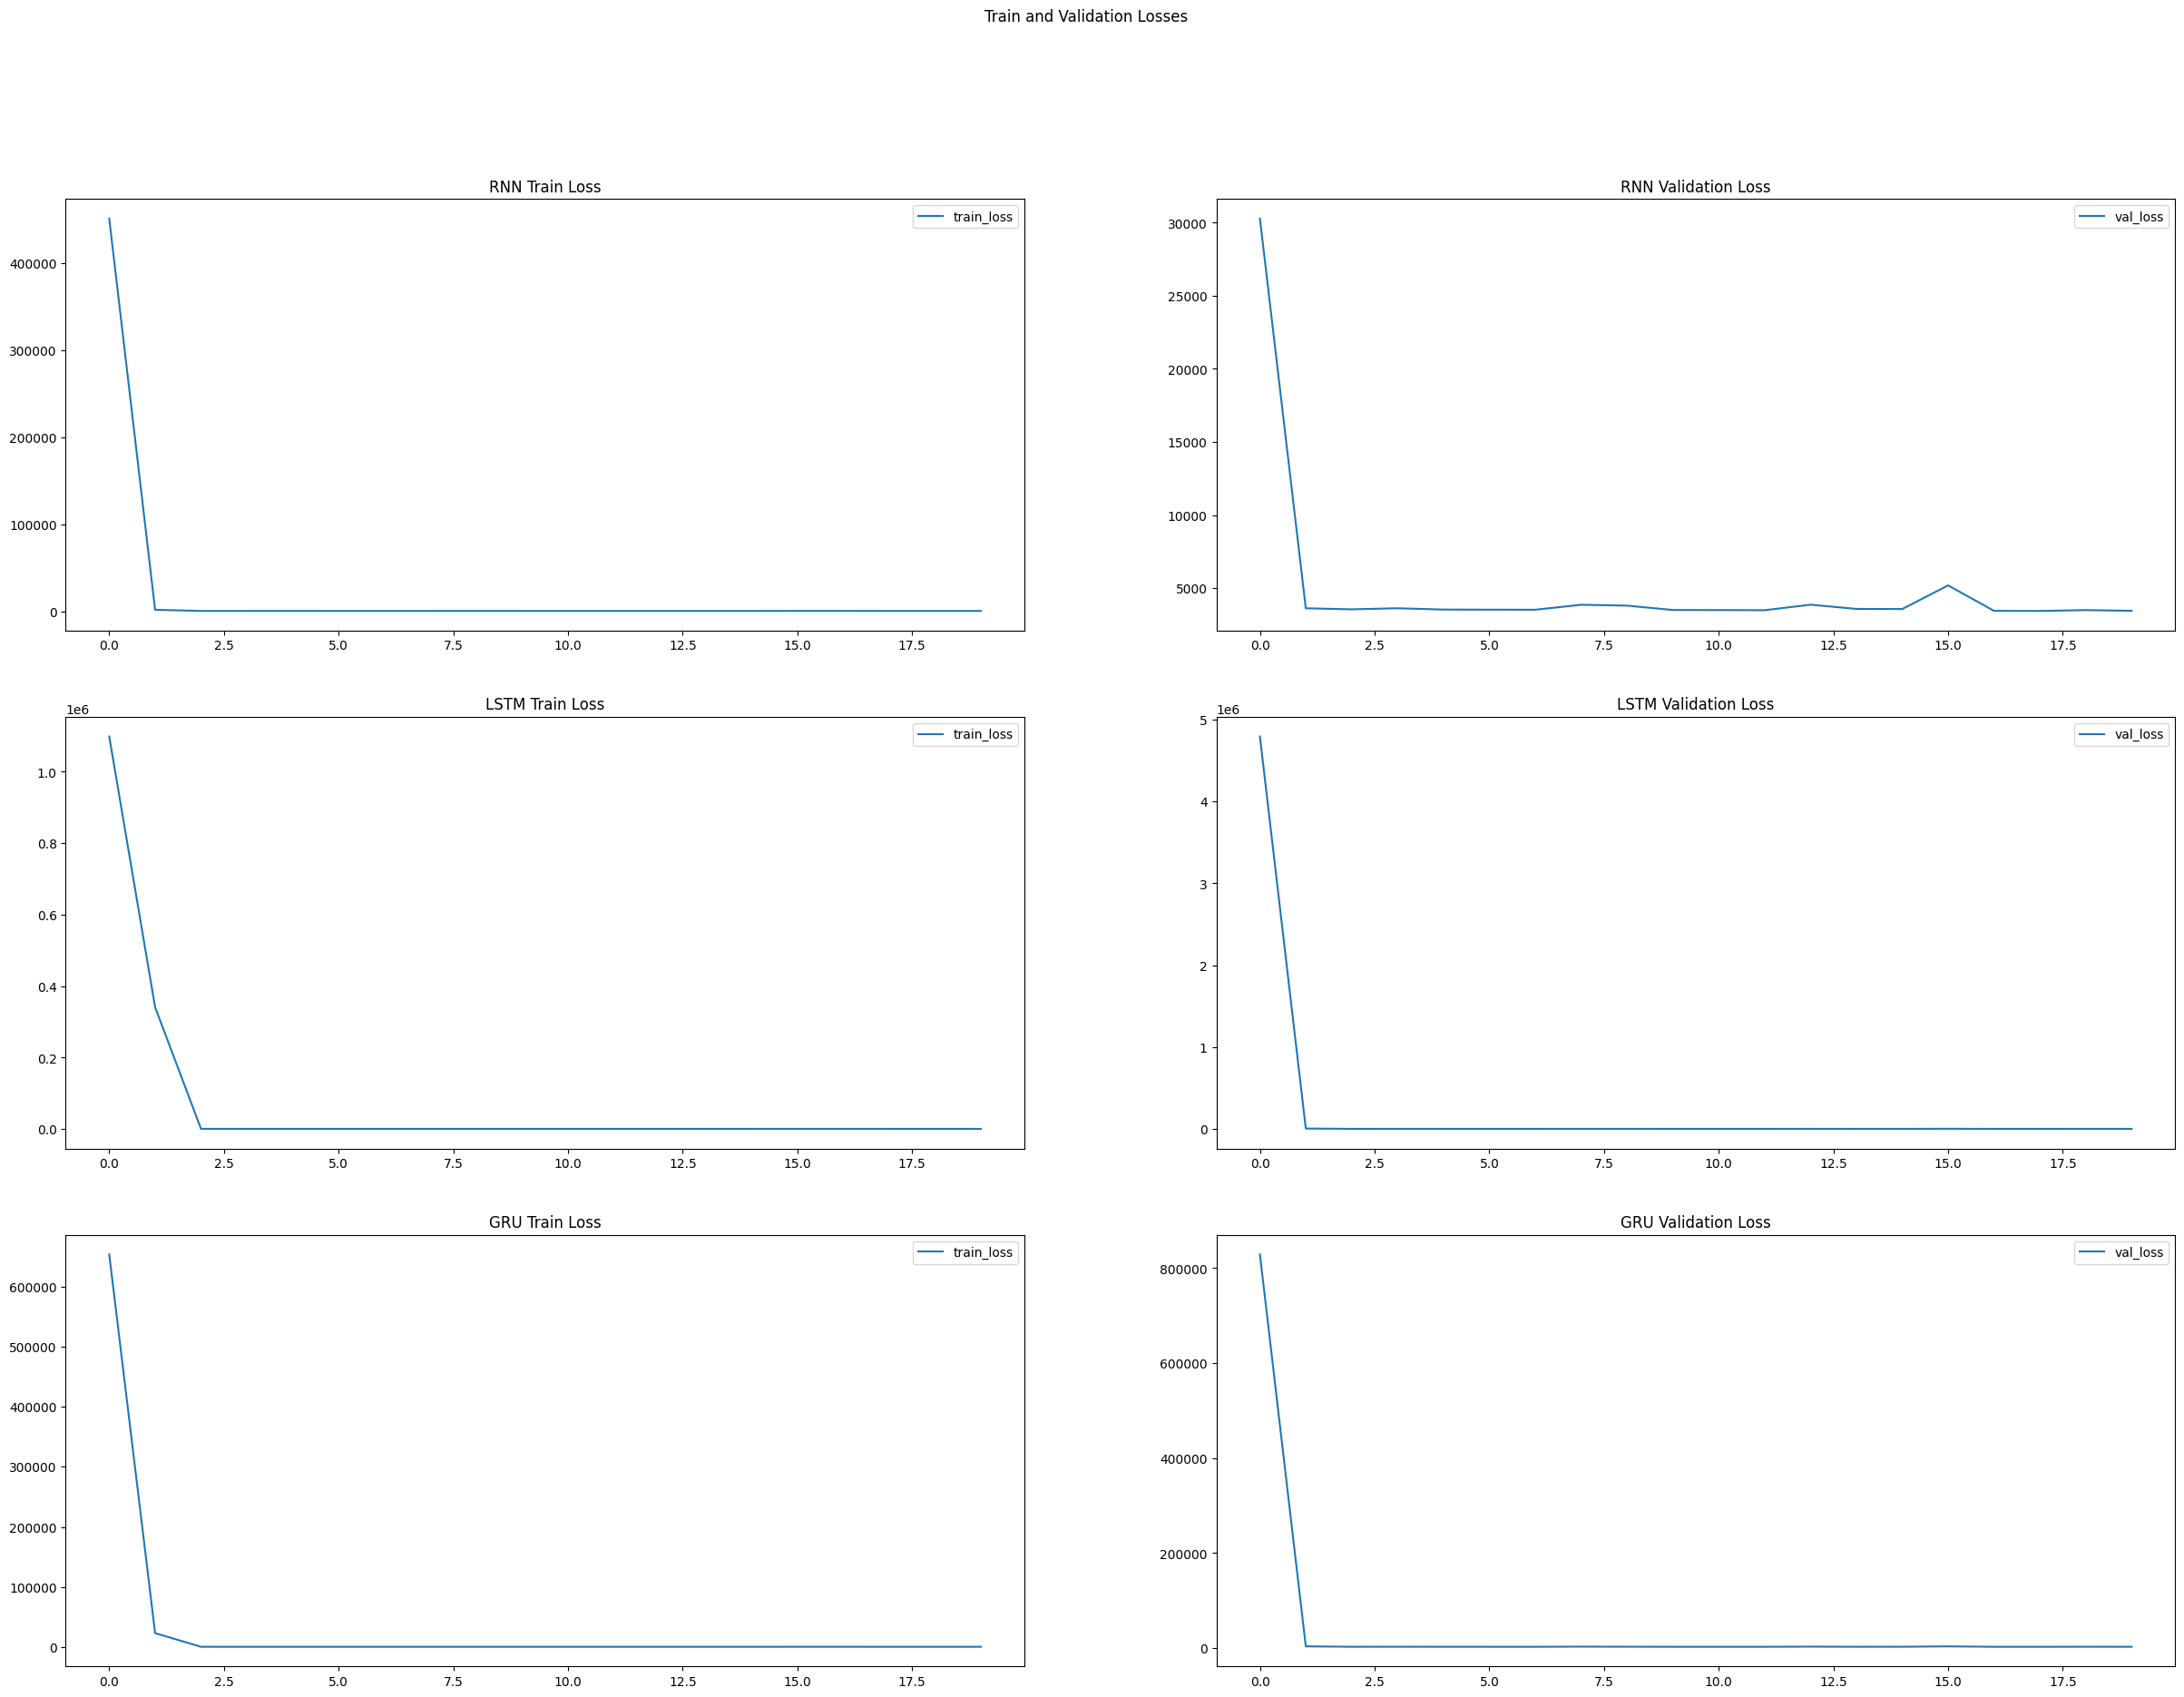

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(30, 21))

axes[0][0].plot(rnn_history[['loss']].index, rnn_history[['loss']], label='train_loss')
axes[0][0].title.set_text('RNN Train Loss')
axes[0][0].legend()

axes[0][1].plot(rnn_history[['val_loss']].index, rnn_history[['val_loss']], label='val_loss')
axes[0][1].title.set_text('RNN Validation Loss')
axes[0][1].legend()

axes[1][0].plot(lstm_history[['loss']].index, lstm_history[['loss']], label='train_loss')
axes[1][0].title.set_text('LSTM Train Loss')
axes[1][0].legend()

axes[1][1].plot(lstm_history[['val_loss']].index, lstm_history[['val_loss']], label='val_loss')
axes[1][1].title.set_text('LSTM Validation Loss')
axes[1][1].legend()

axes[2][0].plot(gru_history[['loss']].index, gru_history[['loss']], label='train_loss')
axes[2][0].title.set_text('GRU Train Loss')
axes[2][0].legend()

axes[2][1].plot(gru_history[['val_loss']].index, gru_history[['val_loss']], label='val_loss')
axes[2][1].title.set_text('GRU Validation Loss')
axes[2][1].legend()
plt.suptitle('Train and Validation Losses')
plt.show()

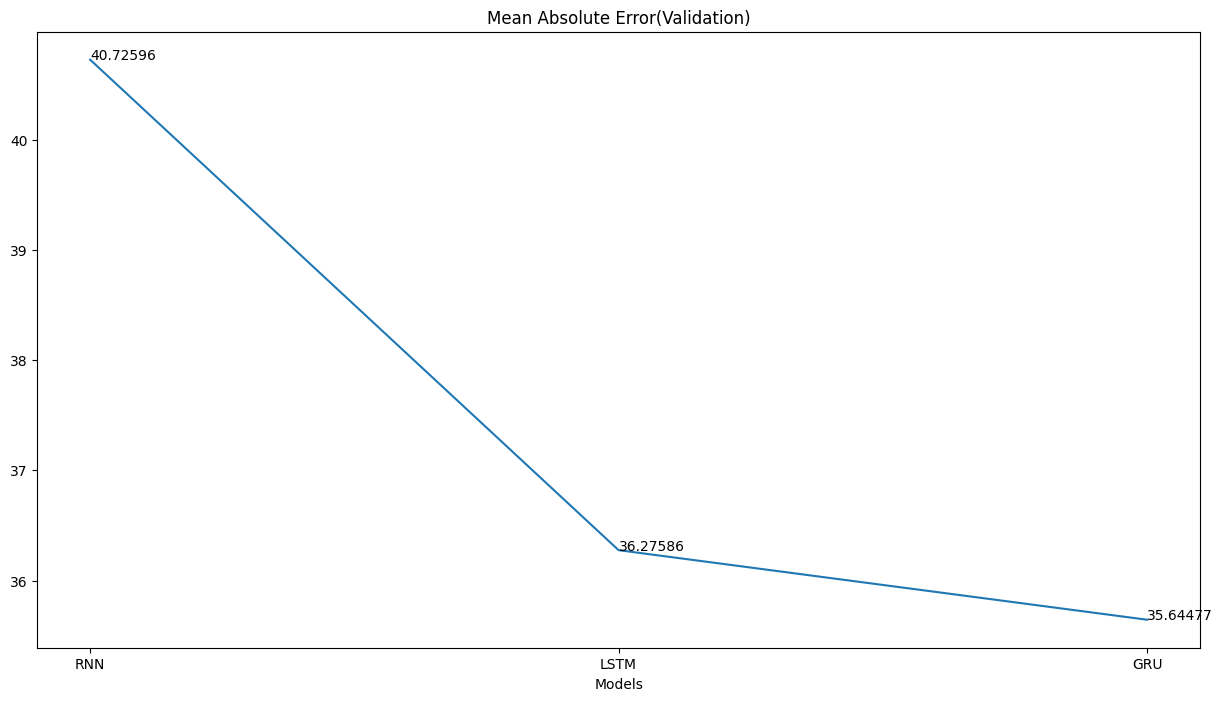

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(['RNN', 'LSTM', 'GRU'], [rnn_val_mae, lstm_val_mae, gru_val_mae])
plt.title('Mean Absolute Error(Validation)')
plt.xlabel('Models')
for index, value in enumerate([rnn_val_mae, lstm_val_mae, gru_val_mae]):
    plt.text(index, value, str(value.numpy()))
plt.show()

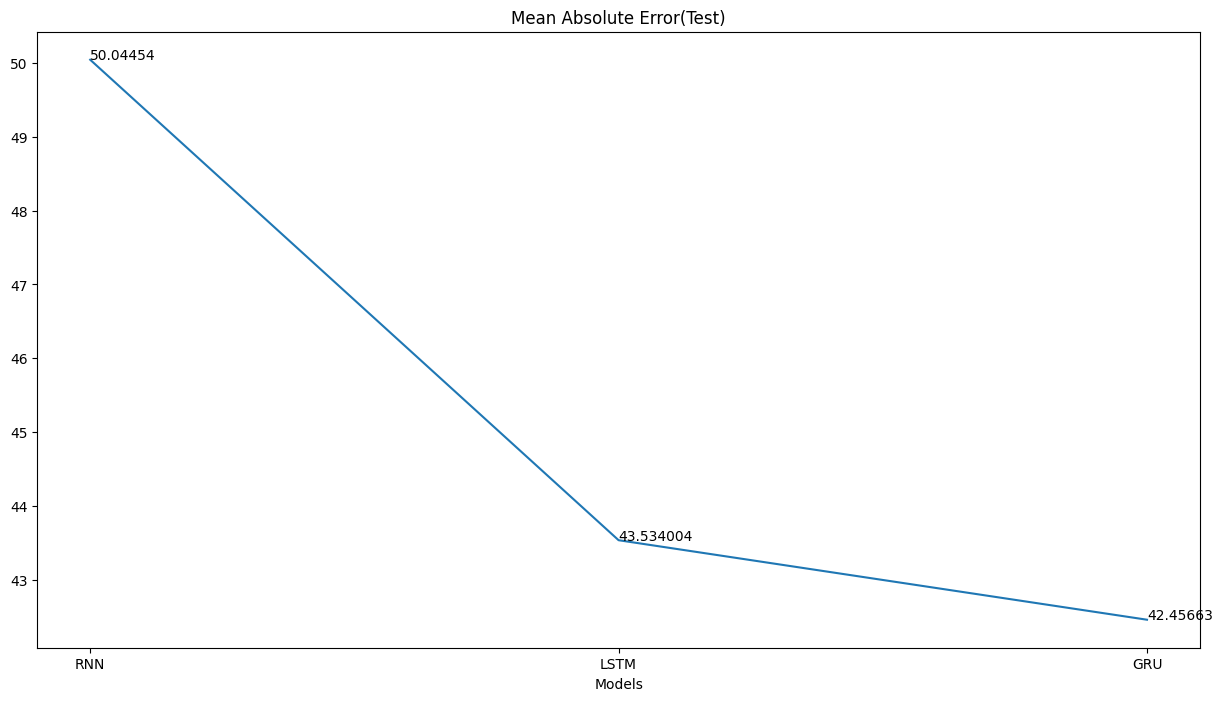

In [29]:
plt.figure(figsize=(15, 8))
plt.plot(['RNN', 'LSTM', 'GRU'], [rnn_test_mae, lstm_test_mae, gru_test_mae])
plt.title('Mean Absolute Error(Test)')
plt.xlabel('Models')
for index, value in enumerate([rnn_test_mae, lstm_test_mae, gru_test_mae]):
    plt.text(index, value, str(value.numpy()))
plt.show()

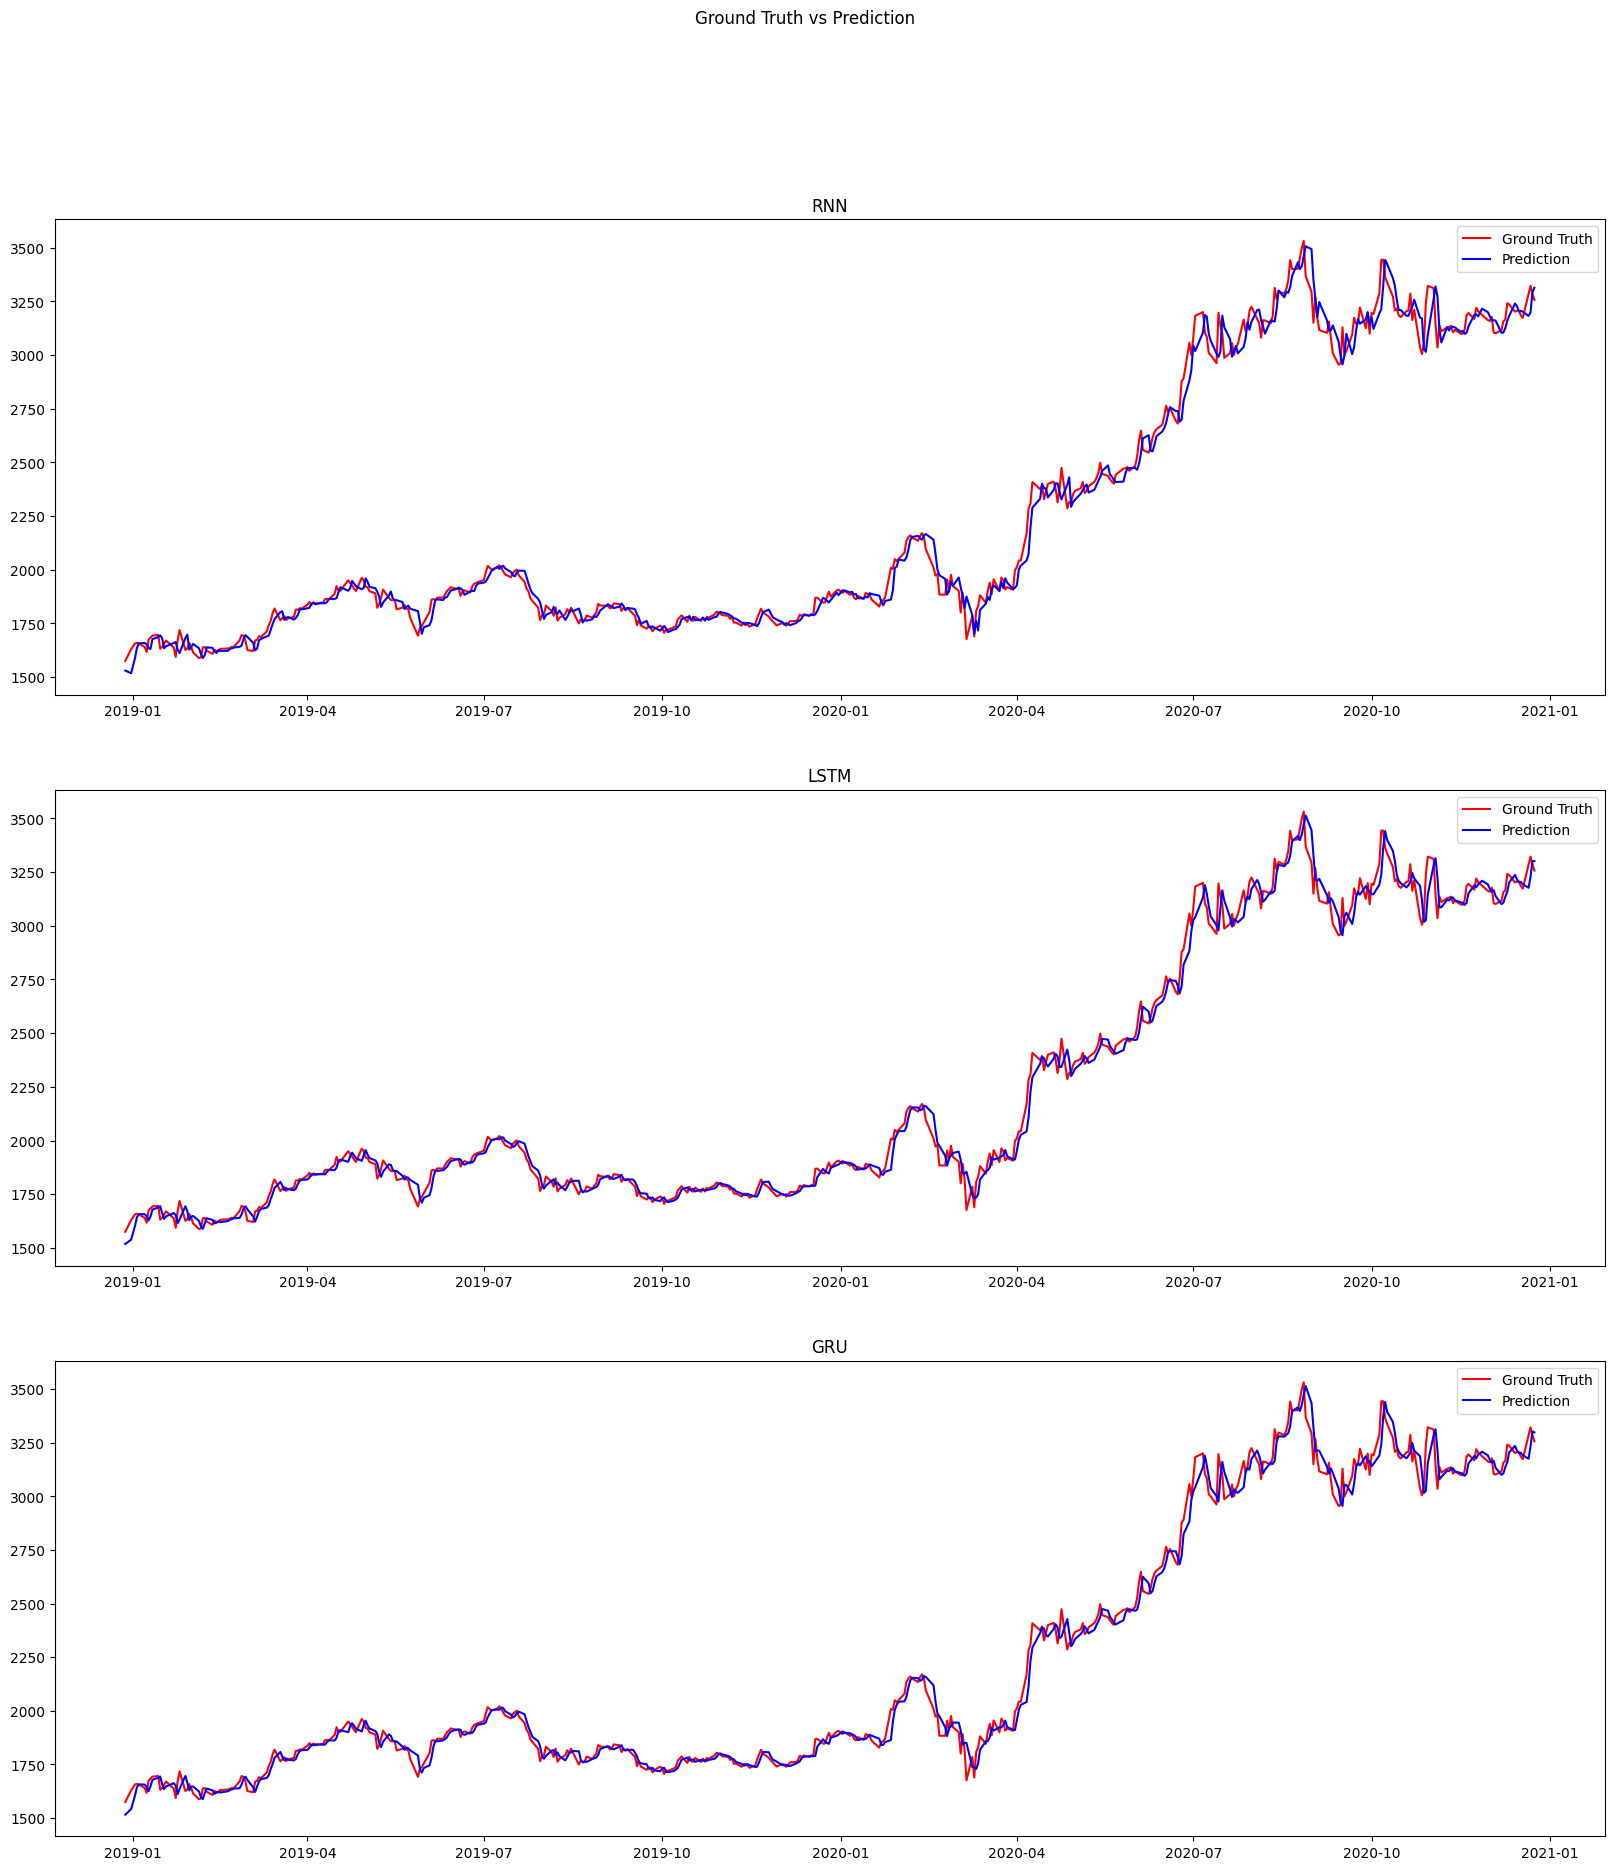

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
axes[0].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, Y_val, color = 'red', label = 'Ground Truth')
axes[0].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, rnn_val_preds, color = 'blue', label = 'Prediction')
axes[0].title.set_text('RNN')
axes[0].legend()

axes[1].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, Y_val, color = 'red', label = 'Ground Truth')
axes[1].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, lstm_val_preds, color = 'blue', label = 'Prediction')
axes[1].title.set_text('LSTM')
axes[1].legend()

axes[2].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, Y_val, color = 'red', label = 'Ground Truth')
axes[2].plot(data[len(Y_train):len(Y_train) + Y_val.shape[0]].index, gru_val_preds, color = 'blue', label = 'Prediction')
axes[2].title.set_text('GRU')
axes[2].legend()
plt.suptitle('Ground Truth vs Prediction')
plt.show()

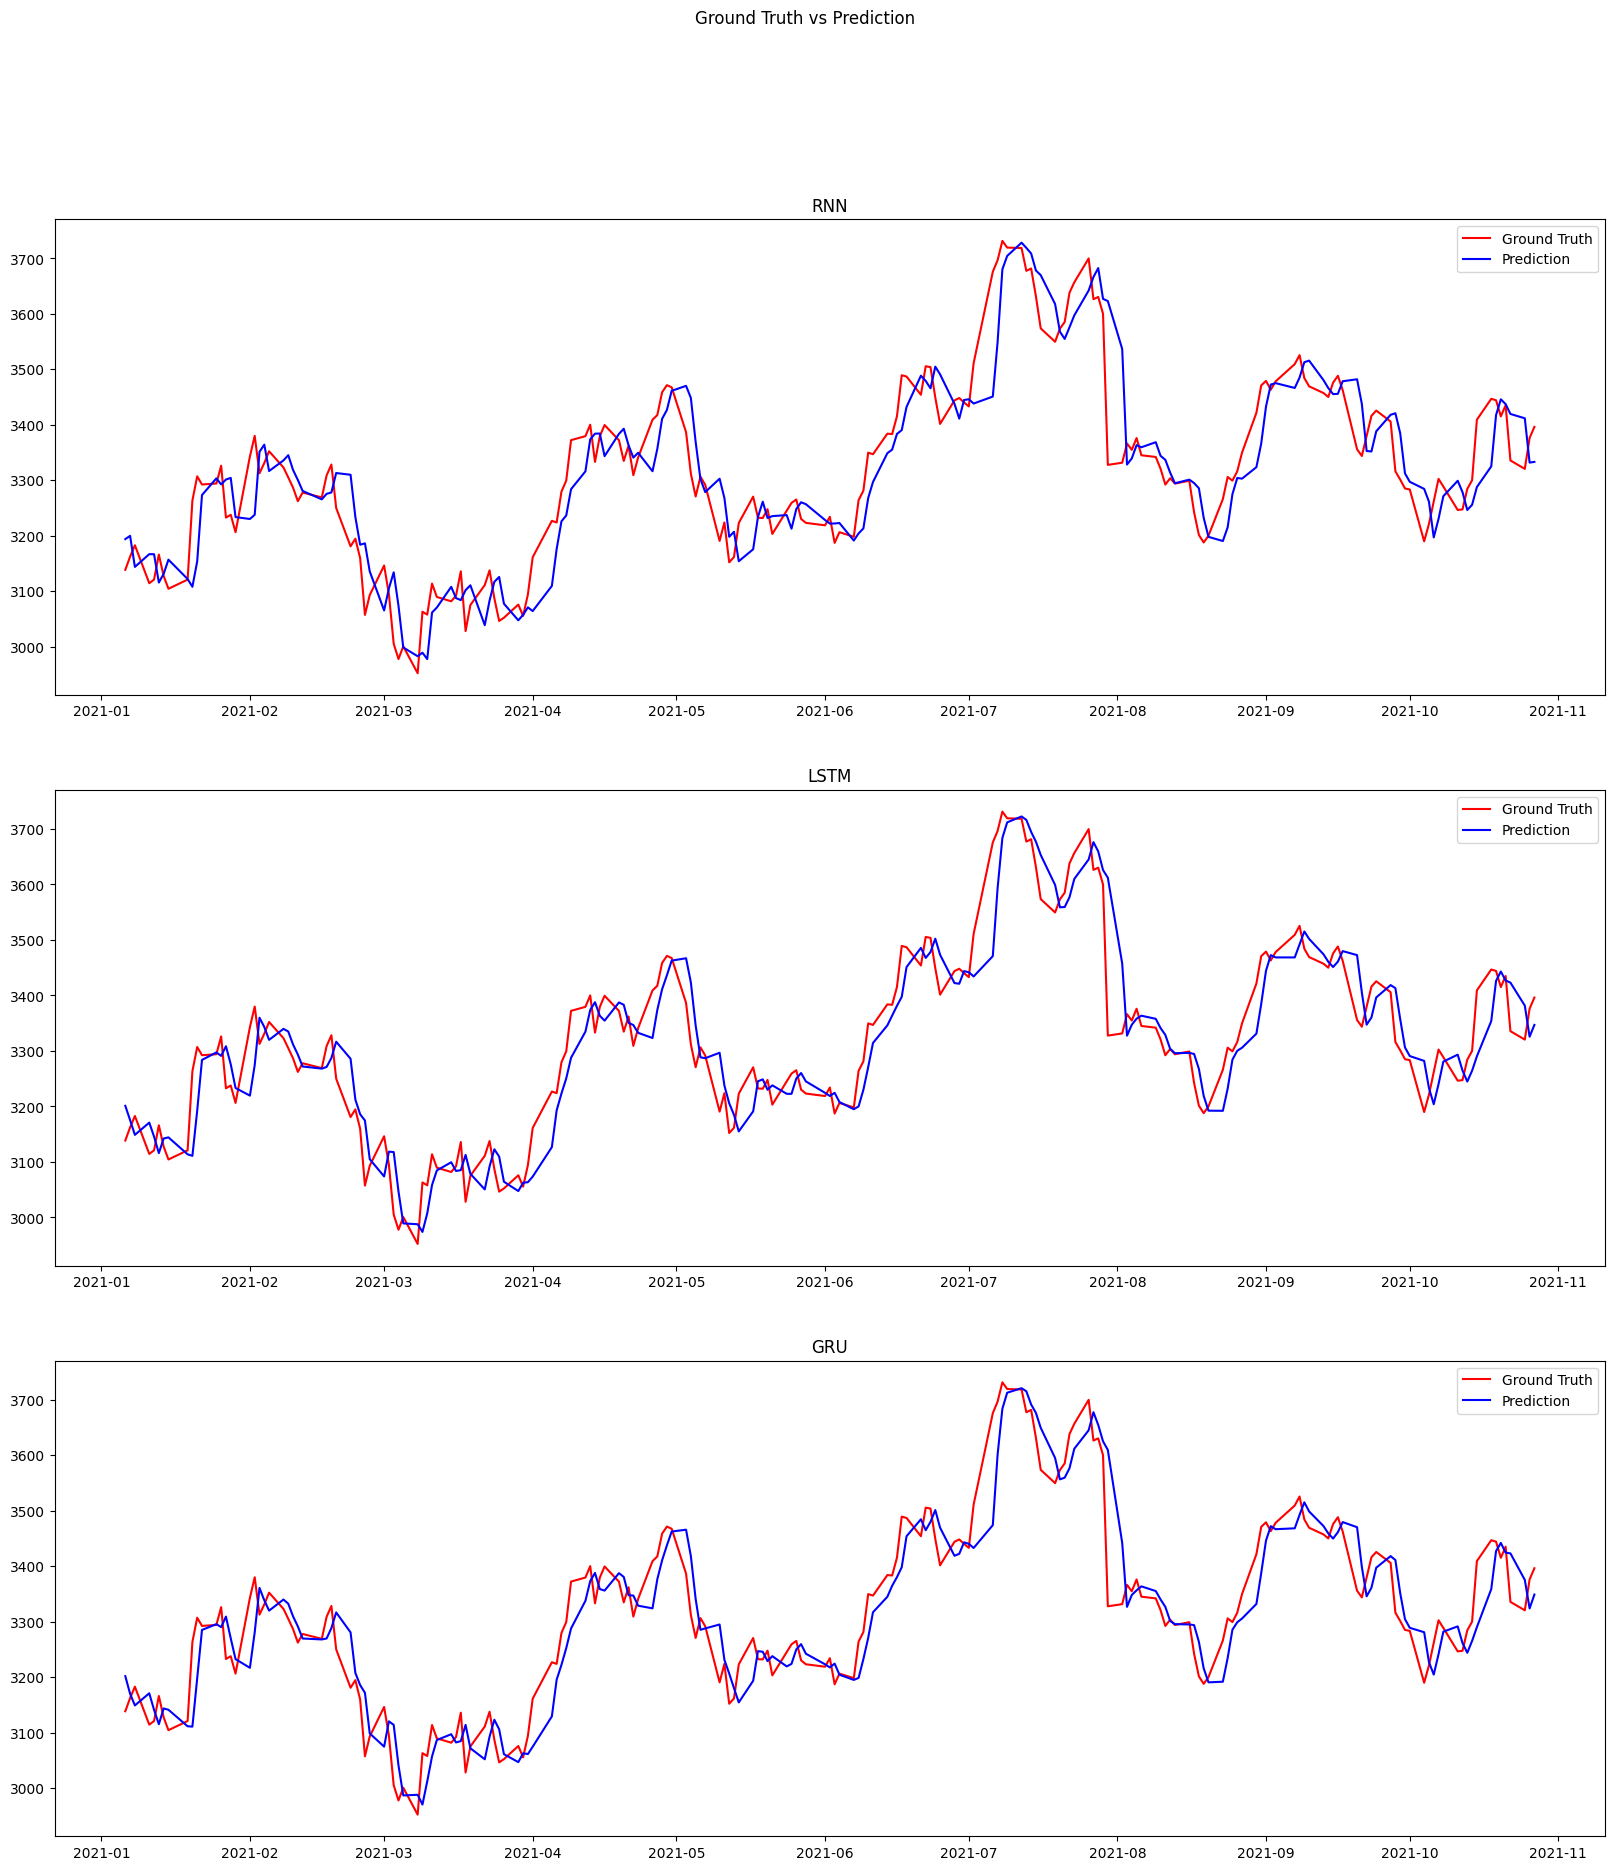

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
axes[0].plot(data[-Y_test.shape[0]:].index, Y_test, color = 'red', label = 'Ground Truth')
axes[0].plot(data[-Y_test.shape[0]:].index, rnn_test_preds, color = 'blue', label = 'Prediction')
axes[0].title.set_text('RNN')
axes[0].legend()

axes[1].plot(data[-Y_test.shape[0]:].index, Y_test, color = 'red', label = 'Ground Truth')
axes[1].plot(data[-Y_test.shape[0]:].index, lstm_test_preds, color = 'blue', label = 'Prediction')
axes[1].title.set_text('LSTM')
axes[1].legend()

axes[2].plot(data[-Y_test.shape[0]:].index, Y_test, color = 'red', label = 'Ground Truth')
axes[2].plot(data[-Y_test.shape[0]:].index, gru_test_preds, color = 'blue', label = 'Prediction')
axes[2].title.set_text('GRU')
axes[2].legend()
plt.suptitle('Ground Truth vs Prediction')
plt.show()

## Compare to feedforward network
Feedforward ANN can be used to solve this problem. The preprocess would be the same, we can still have sequence length = 2 and number of data points=N. So our input would be (N, 2, 1) and after batching, we have (B, N, 2, 1). The target is still (N, 1). This can be fed to a feedforward network(like CNN). Here is a simple example.

In [32]:
cnn_series = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
cnn_data, cnn_target = split_series(pd.DataFrame(np.array(cnn_series)), 3)
print(f"X_train shape: {cnn_data.shape}, Y_train shape: {cnn_target.shape}")
print(cnn_data)

X_train shape: (7, 3, 1), Y_train shape: (7, 1)
[[[100]
  [110]
  [120]]

 [[110]
  [120]
  [130]]

 [[120]
  [130]
  [140]]

 [[130]
  [140]
  [150]]

 [[140]
  [150]
  [160]]

 [[150]
  [160]
  [170]]

 [[160]
  [170]
  [180]]]


In [33]:
cnn_model_50 = models.Sequential()
cnn_model_50.add(layers.Conv1D(64, 2, activation='relu', input_shape=(3, 1)))
cnn_model_50.add(layers.MaxPooling1D(2))
cnn_model_50.add(layers.Flatten())
cnn_model_50.add(layers.Dense(100))
cnn_model_50.add(layers.Dense(1))
cnn_model_50.compile(optimizer='adam', loss='mean_squared_error')
cnn_history_500 = cnn_model_50.fit(cnn_data, cnn_target, epochs=50, verbose=0)
print(f"500 epochs: {cnn_model_50.predict(np.array([170, 180, 190]).reshape(1, 3, 1))}")

cnn_model_10000 = models.Sequential()
cnn_model_10000.add(layers.Conv1D(64, 2, activation='relu', input_shape=(3, 1)))
cnn_model_10000.add(layers.MaxPooling1D(2))
cnn_model_10000.add(layers.Flatten())
cnn_model_10000.add(layers.Dense(100))
cnn_model_10000.add(layers.Dense(1))
cnn_model_10000.compile(optimizer='adam', loss='mean_squared_error')
cnn_history_10000 = cnn_model_10000.fit(cnn_data, cnn_target, epochs=10000, verbose=0)
print(f"10000 epochs: {cnn_model_10000.predict(np.array([170, 180, 190]).reshape(1, 3, 1))}")

1/1 [==============================] - 0s 49ms/step
500 epochs: [[195.25307]]
1/1 [==============================] - 0s 48ms/step
10000 epochs: [[201.6586]]


However, we may need to construct a very deep(large number of hidden layers) and complicated(large number of hidden units in a hidden layer) model for real problems. The training time will increase and the performance may still be worse compare to RNN's. Actaully, in the above example we can actaully see that the result from 50 epochs is quite unacceptable and we need 10k epochs to get an acceptable result. Moreover, with such a feedforward model and real world problems we may experience gradient vanishing or exploding problems. Therefore, using feedforward network is not a good choice for such task.

## Word Embedding

Pretrained word embedding url: https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1  
Dissimilarity: Chebyshev Distance, calculated as max( (x_i - y_i) ) meaning the distance is the greatest of their difference along any coordinate dimension. Therefore, as we have the embeddings and treat them as vector points in vector space, the larger distance means the more likely that the two words are dissimilar.

In [34]:
strings = ["", ""]
strings[0] = input("Word 1: ")
strings[1] = input("Word 2: ")
print(strings)

['this', 'that']


In [35]:
embed = tfhub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1")

In [36]:
embeddings = embed(strings)
embeddings[0], embeddings[1]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.17849712, -0.04519277, -0.01800628,  0.03167261, -0.01759489,
        -0.05665898, -0.10084513,  0.04446944,  0.1136525 , -0.04387722,
        -0.05736724, -0.14388299, -0.05745615, -0.15731575, -0.10375199,
        -0.09802415,  0.00594332,  0.03937301,  0.0162055 ,  0.32337016,
        -0.01261148,  0.01625825,  0.14830582, -0.01721515,  0.08470592,
         0.01847644, -0.04344172, -0.09091296, -0.07765199,  0.07118276,
        -0.13054818, -0.02156414,  0.0047634 , -0.00123568, -0.0398718 ,
         0.06864961, -0.22894152, -0.03905505, -0.06981597, -0.03733263,
        -0.19146273,  0.01546862, -0.04202671,  0.16990612, -0.03966084,
        -0.07017914, -0.02287517, -0.19194342, -0.01852768,  0.02617534,
        -0.07232048, -0.01232366, -0.15919487,  0.11414526, -0.05757218,
         0.00601415,  0.00822029,  0.05547604, -0.02839203,  0.03645862,
         0.01695746, -0.06488681,  0.05952214, -0.03191975,  0.08337681,
  

In [37]:
cosine_similarity = np.dot(embeddings[0].numpy(), embeddings[1].numpy())/ (np.linalg.norm(embeddings[0].numpy()) * np.linalg.norm(embeddings[1].numpy()))
dissimilarity = chebyshev(embeddings[0].numpy(), embeddings[1].numpy())

In [38]:
print(f'Cosine Similarity: {cosine_similarity:.4f}')
print(f'Dissimilarity: {dissimilarity}')

Cosine Similarity: 0.4262
Dissimilarity: 0.2570379674434662
